# Test of various machine learning algorithms on our dataset
## Algorithms tested:
###    * Linear regression using PyTorch
###    * Support vector machine (SVM) regression
###    * K-nearest neighbors (KNN) regression
###    * Radius nearest neghbors (RNN) regression
###    * Decision tree regression
    
### KNN regression performed best, so it was included in the final report

----------------------------------------------------------------------------------

## Featurization function 
### Function to featurize input data

In [1]:
from ase.io import read,write
import pymatgen
from pymatgen.analysis.local_env import VoronoiNN
from scipy.spatial import Voronoi, SphericalVoronoi
from pymatgen.io.ase import AseAtomsAdaptor
import os
import pickle
import uuid
import json
from collections import OrderedDict, Iterable, Mapping
from multiprocess import Pool
import numpy as np
import gc
import tqdm
import ase.io
from ase import Atoms
from ase.constraints import FixAtoms
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.analysis.local_env import VoronoiNN
from pymatgen.analysis.adsorption import AdsorbateSiteFinder
import numpy as np
from numpy import genfromtxt
from os import listdir
import time 
import pandas as pd
import random
import torch
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
from torch.autograd import Variable

def fingerprint_atoms_2(atoms):
    '''
    This function is used to fingerprint an adslabs atoms object, where the "fingerprint" is a
    dictionary of properties that we believe may be adsorption motifs.
    Inputs:
        atoms   Atoms object to fingerprint. The slab atoms must be tagged with 0 and
                adsorbate atoms must be tagged with non-zero integers. This function also
                assumes that the first atom in each adsorbate is the binding atom (e.g.,
                of all atoms with tag==1, the first atom is the binding; the same goes for
                tag==2 and tag==3 etc.).
    '''
#     # Remove the adsorbate(s) while finding the binding position(s)
#     atoms, binding_positions = remove_adsorbate(atoms)
#     # Add Uranium atoms at each of the binding sites so that we can use them for fingerprinting.
#     for tag in binding_positions:
#         atoms += Atoms('U', positions=[binding_positions[tag]])

    # Turn the atoms into a pymatgen structure object so that we can use the VCF to find
    # the coordinated sites.
    struct = AseAtomsAdaptor.get_structure(atoms)

    #Test to see if the central atom is entirely on it's own, if so it is not coordinated, so skip the voronoi bit
    # which would throw a QHULL error
    num_cutoff_neighbors = [site[0] for site in enumerate(struct) if 0.1 < struct[len(atoms)-1].distance(site[1]) < 7.0]
    if len(num_cutoff_neighbors) == 0:
        return {'coordination': '',
                'neighborcoord': '',
                'natoms': len(atoms),
                'nextnearestcoordination': ''}

    vnn = VoronoiNN(allow_pathological=True, tol=0.8, cutoff=10)
    vnn_loose = VoronoiNN(allow_pathological=True, tol=0.2, cutoff=10)
    try:
        coordinated_atoms_data = vnn.get_nn_info(struct, len(atoms)-1)
    except ValueError:
        vnn = VoronoiNN(allow_pathological=True, tol=0.8, cutoff=40)
        vnn_loose = VoronoiNN(allow_pathological=True, tol=0.2, cutoff=40)
        coordinated_atoms_data = vnn.get_nn_info(struct, len(atoms)-1)
    coordinated_atoms = [atom_data['site'] for atom_data in coordinated_atoms_data]
    # Create a list of symbols of the coordinations, remove uranium from the list, and
    # then turn the list into a single, human-readable string.
    coordinated_symbols = map(lambda x: x.species_string, coordinated_atoms)
    coordinated_symbols = [a for a in coordinated_symbols if a not in ['U']]
    coordination = '-'.join(sorted(coordinated_symbols))

    # Make a [list] of human-readable coordination sites [unicode] for all of the slab atoms
    # that are coordinated to the adsorbate, "neighborcoord"
    neighborcoord = []
    for i in coordinated_atoms:
        # [int] that yields the slab+ads system's atomic index for the 1st-tier-coordinated atom
        neighborind = [site[0] for site in enumerate(struct) if i.distance(site[1]) < 0.1][0]
        # [list] of PyMatGen [periodic site class]es for each of the atoms that are coordinated
        # with the adsorbate
        coord_data = vnn_loose.get_nn_info(struct, neighborind)
        coord = [atom_data['site'] for atom_data in coord_data]
        # The elemental symbols for all of the 2nd-tier-coordinated atoms in a [list] of
        # [unicode] objects
        coord_symbols = map(lambda x: x.species_string, coord)
        # Take out atoms that we assume are not part of the slab
        coord_symbols = [a for a in coord_symbols if a not in ['U']]
        # Sort the list of 2nd-tier-coordinated atoms to induce consistency
        coord_symbols.sort()
        # Turn the [list] of [unicode] values into a single [unicode]
        neighborcoord.append(i.species_string+':'+'-'.join(coord_symbols))

    # [list] of PyMatGen [periodic site class]es for each of the atoms that are
    # coordinated with the adsorbate
    coordinated_atoms_nextnearest_data = vnn_loose.get_nn_info(struct, len(atoms)-1)
    coordinated_atoms_nextnearest = [atom_data['site'] for atom_data in coordinated_atoms_nextnearest_data]
    # The elemental symbols for all of the coordinated atoms in a [list] of [unicode] objects
    coordinated_symbols_nextnearest = map(lambda x: x.species_string,
                                          coordinated_atoms_nextnearest)
    # Take out atoms that we assume are not part of the slab
    coordinated_symbols_nextnearest = [a for a in coordinated_symbols_nextnearest
                                       if a not in ['U']]
    # Turn the [list] of [unicode] values into a single [unicode]
    coordination_nextnearest = '-'.join(sorted(coordinated_symbols_nextnearest))

    # Return a dictionary with each of the fingerprints. Any key/value pair can be added here
    # and will propagate up the chain
    return {'coordination': coordination,
            'neighborcoord': neighborcoord,
            'natoms': len(atoms),
            'nextnearestcoordination': coordination_nextnearest}

def nearest_neighbor_count(neighbors,atom_type):
#Takes neighbors as a dictionary object and the atom type whose coordination number
#we are interested in 
#The neighbor object is within a cut off radius of 7 Angstrom
    C=neighbors['coordination']    
    return C.count(atom_type)

def next_nearest_neighbor_count(neighbors,atom_type):
#Takes neighbors as a dictionary object and the atom type whose coordination number
#we are interested in 
#The neighbor object is within a cut off radius of 7 Angstrom
    N=neighbors['neighborcoord']
    NN=neighbors['nextnearestcoordination']
    N_count=0
    for i in range(len(N)):
        s=N[i]
        sub_s=s[s.index(':') + len(':'):]
        N_count+=sub_s.count(atom_type)
    return N_count

# Create Gaussian distributions and write to xlsx
def ret_Gaussian(mu,sigma,N):
    s = np.random.normal(mu, sigma, N)
    return s


def featurize_new(atoms):
    a=fingerprint_atoms_2(atoms)
    C=a['coordination']
    N=a['neighborcoord']
    NN=a['nextnearestcoordination']
    neighbor_types=['S','Co', 'Ti', 'Cu', 'Mn', 'Mo', 'V', 'Ru', 'Sc']
    atom_number=np.array([16,27,22,29,25,42,23,44,21])
    chi=np.array([2.58,1.88,1.54,1.92,1.90,1.55,2.16,1.63,2.2,1.36])

    std_GOH = np.array([0.17,0.19,0.16,0.20,0.21,0.21,0.15,0.12,0.13])
    feature_vec=np.zeros((3,2*len(neighbor_types)))
    for i in range(len(neighbor_types)):
        if nearest_neighbor_count(a,neighbor_types[i])!=0:
            feature_vec[:,i]=(np.array([atom_number[i],chi[i],nearest_neighbor_count(a,neighbor_types[i])])).T
        else:
            feature_vec[:,i]=(np.array([0,0,0])).T
    for i in range(len(neighbor_types)):
        if next_nearest_neighbor_count(a,neighbor_types[i])!=0:
            feature_vec[:,i+len(neighbor_types)]=(np.array([atom_number[i],chi[i],next_nearest_neighbor_count(a,neighbor_types[i])])).T
        else:
            feature_vec[:,i+len(neighbor_types)]=(np.array([0,0,0])).T

    return feature_vec


## Loading big data saved in location 

In [2]:
## Big Data
## Fetching DGOH data all sulfide classes

import numpy as np
from numpy import genfromtxt
from os import listdir
import time 
import pandas as pd
import random
import torch
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
from torch.autograd import Variable
comp = ['CoS','CuS','MnS','MoS','RuS','ScS','TiS','VS']


####################################################
#loading all file names 
def find_xyz_filenames( path_to_dir, suffix=".xyz" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

path='swapped_data_for_featurizing'
CoS_filenames = find_xyz_filenames(path+'/CoS')
CuS_filenames = find_xyz_filenames(path+'/CuS')
MnS_filenames = find_xyz_filenames(path+'/MnS')
MoS_filenames = find_xyz_filenames(path+'/MoS')
RuS_filenames = find_xyz_filenames(path+'/RuS')
ScS_filenames = find_xyz_filenames(path+'/ScS')
TiS_filenames = find_xyz_filenames(path+'/TiS')
VS_filenames = find_xyz_filenames(path+'/VS')


#####################################################
#loading the excel file
def find_xlsx_filenames( path_to_dir, suffix=".xlsx" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

xlsx_filenames = find_xlsx_filenames('data')



######################################################
#loading xlsx data
path ='data/'+xlsx_filenames[0]

##reading the data from each sheet
df = pd.read_excel(path,sheet_name=0)
delta_g_CoS = df[df.columns[0]]
ads_CoS = df[df.columns[1]]

df = pd.read_excel(path,sheet_name=1)
delta_g_CuS = df[df.columns[0]]
ads_CuS = df[df.columns[1]]

df = pd.read_excel(path,sheet_name=2)
delta_g_MnS = df[df.columns[0]]
ads_MnS = df[df.columns[1]]

df = pd.read_excel(path,sheet_name=3)
delta_g_TiS = df[df.columns[0]]
ads_TiS = df[df.columns[1]]

df = pd.read_excel(path,sheet_name=4)
delta_g_RuS = df[df.columns[0]]
ads_RuS = df[df.columns[1]]

df = pd.read_excel(path,sheet_name=5)
delta_g_MoS = df[df.columns[0]]
ads_MoS = df[df.columns[1]]

df = pd.read_excel(path,sheet_name=6)
delta_g_ScS = df[df.columns[0]]
ads_ScS = df[df.columns[1]]


df = pd.read_excel(path,sheet_name=7)
delta_g_VS = df[df.columns[0]]
ads_VS = df[df.columns[1]]

std_GOH = np.array([0.17,0.19,0.16,0.20,0.21,0.21,0.15,0.12,0.13])

N=30
j=0
vec_Co=np.zeros((len(delta_g_CoS),N))
for i in range(len(delta_g_CoS)):
    vec_Co[i,:]=(ret_Gaussian(delta_g_CoS[i],std_GOH[j],N)).T
j=j+1

vec_Cu=np.zeros((len(delta_g_CuS),N))
for i in range(len(delta_g_CuS)):
    vec_Cu[i,:]=ret_Gaussian(delta_g_CuS[i],std_GOH[j],N)
j=j+1

vec_Mn=np.zeros((len(delta_g_MnS),N))
for i in range(len(delta_g_MnS)):
    vec_Mn[i,:]=ret_Gaussian(delta_g_MnS[i],std_GOH[j],N)
j=j+1

vec_Ti=np.zeros((len(delta_g_TiS),N))
for i in range(len(delta_g_TiS)):
    vec_Ti[i,:]=ret_Gaussian(delta_g_TiS[i],std_GOH[j],N)
j=j+1

vec_Ru=np.zeros((len(delta_g_RuS),N))
for i in range(len(delta_g_RuS)):
    vec_Ru[i,:]=ret_Gaussian(delta_g_RuS[i],std_GOH[j],N)
j=j+1

vec_Mo=np.zeros((len(delta_g_MoS),N))
for i in range(len(delta_g_MoS)):
    vec_Mo[i,:]=ret_Gaussian(delta_g_MoS[i],std_GOH[j],N)
j=j+1

vec_Sc=np.zeros((len(delta_g_ScS),N))
for i in range(len(delta_g_ScS)):
    vec_Sc[i,:]=ret_Gaussian(delta_g_ScS[i],std_GOH[j],N)
j=j+1

vec_V=np.zeros((len(delta_g_VS),N))
for i in range(len(delta_g_VS)):
    vec_V[i,:]=ret_Gaussian(delta_g_VS[i],std_GOH[j],N)
j=j+1

vec_Co_reshape=np.reshape(vec_Co.T,(vec_Co.T.size,1))
vec_Cu_reshape=np.reshape(vec_Cu.T,(vec_Cu.T.size,1))
vec_Mn_reshape=np.reshape(vec_Mn.T,(vec_Mn.T.size,1))
vec_Ti_reshape=np.reshape(vec_Ti.T,(vec_Ti.T.size,1))
vec_Ru_reshape=np.reshape(vec_Ru.T,(vec_Ru.T.size,1))
vec_Mo_reshape=np.reshape(vec_Mo.T,(vec_Mo.T.size,1))
vec_Sc_reshape=np.reshape(vec_Sc.T,(vec_Sc.T.size,1))
vec_V_reshape=np.reshape(vec_V.T,(vec_V.T.size,1))
                         
                          
DGOH=np.hstack((vec_Co_reshape.T,vec_Cu_reshape.T,vec_Mn_reshape.T,vec_Ti_reshape.T,vec_Ru_reshape.T,vec_Mo_reshape.T,vec_Sc_reshape.T,vec_V_reshape.T))
print(DGOH.shape)


(1, 1470)


## Creation of feature matrix using the input data

In [3]:
## Building feature vector from all sulfides


def fetchdata(filenames,stringname,size):
    neighbor_types=['S','Co', 'Cr', 'Cu', 'Mn', 'Mo', 'V', 'Ru', 'Sc']
    featureVectorStack=np.zeros((3,2*len(neighbor_types),size))
    path='swapped_data_for_featurizing'
    r = 0
    for i in range(0,len(filenames)):
        atoms=read(path+'/'+stringname+'/'+str(i)+'.xyz')
        featureVectorStack[:,:,i]=featurize_new(atoms)
    return featureVectorStack
        
       
FV1=fetchdata(CoS_filenames,'CoS',len(delta_g_CoS)*N)  
print('Co done')
FV2=fetchdata(CuS_filenames,'CuS',len(delta_g_CuS)*N)  
print('Cu done')
FV3=fetchdata(MnS_filenames,'MnS',len(delta_g_MnS)*N)  
print('Mn done')
FV4=fetchdata(TiS_filenames,'TiS',len(delta_g_TiS)*N)
print('Ti done')
FV5=fetchdata(RuS_filenames,'RuS',len(delta_g_RuS)*N)  
print('Ru done')
FV6=fetchdata(MoS_filenames,'MoS',len(delta_g_MoS)*N)  
print('Mo done')
FV7=fetchdata(ScS_filenames,'ScS',len(delta_g_ScS)*N)  
print('Sc done')
FV8=fetchdata(VS_filenames,'VS',len(delta_g_VS)*N)  
print('V done')
FV=np.dstack((FV1,FV2,FV3,FV4,FV5,FV6,FV7,FV8))




Co done
Cu done
Mn done
Ti done
Ru done
Mo done
Sc done
V done


In [42]:
print(len(CoS_filenames))

r,c,d=FV.shape
print (FV.shape)
FV_reshape = FV.reshape((r*c,d))

print (DGOH.T.shape)
print (FV[1,:,:])


210
(3, 18, 1470)
(1470, 1)
[[2.58 2.58 0.   ... 0.   0.   0.  ]
 [0.   0.   1.88 ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 2.16 2.16 2.16]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]]


# 1. **Linear Regression Using PyTorch**
Linear regression model using PyTorch to compare against sklearn machine learning models

In [60]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import torch.nn.functional as F

In [61]:
#split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(FV_reshape.T, DGOH.T, test_size=0.33, random_state=42,shuffle= True)

In [62]:
#normalize
DGOH_new = (DGOH-np.mean(DGOH))/np.std(DGOH)
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(FV_reshape.T, DGOH_new.T, test_size=0.33, random_state=42,shuffle= True)

In [63]:
print(X_train)


[[16.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [16.  0.  0. ...  0.  3.  0.]
 [ 0.  0.  0. ... 11.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


In [64]:
train_data = torch.FloatTensor(np.array(X_train))
dg = np.array(y_train)

del_g =  torch.FloatTensor(dg)
x,y = Variable(train_data), Variable (del_g)



In [65]:
n_in, n_h1,n_h2,n_h3, n_out, batch_size = 54, 54,54,54, 1, 20

# Create a model
model = nn.Sequential(nn.Linear(n_in, n_out))


# Construct the loss function
criterion = torch.nn.MSELoss()

# Construct the optimizer (Stochastic Gradient Descent in this case)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Gradient Descent
for epoch in range(10000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if epoch%1000 == 0:
        print('epoch: ', epoch,' loss: ', loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()



epoch:  0  loss:  20.413084030151367
epoch:  1000  loss:  1.348575234413147
epoch:  2000  loss:  0.27286359667778015
epoch:  3000  loss:  0.20065096020698547
epoch:  4000  loss:  0.1654365062713623
epoch:  5000  loss:  0.14060968160629272
epoch:  6000  loss:  0.12365183979272842
epoch:  7000  loss:  0.1133887842297554
epoch:  8000  loss:  0.1083713248372078
epoch:  9000  loss:  0.10582780838012695


0.31280240621214117


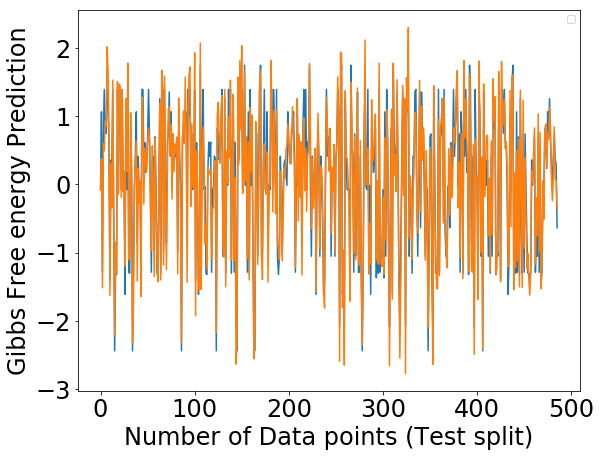

In [66]:
test_data = torch.FloatTensor(np.array(X_test))

x_test =  Variable(test_data)
y_pred_test = model(test_data)
y1_pred = y_pred_test.detach().numpy()
y1  = y_test


fig1 = plt.figure(figsize=(9,7))

plt.legend(['Prediction','Actual Data'])

plt.xlabel('Number of Data points (Test split)', fontsize=24)
plt.ylabel('Gibbs Free energy Prediction', fontsize=24)
plt.tick_params(labelsize=24)

plt.plot(range(0,len(y1_pred)),y1_pred)
plt.plot(range(0,len(y1)),y1)
print (np.std(y1_pred-y1))

# 2. **Running our data through different ML Algorithms**
Feature matrix was flattened to a 2D input before applying ML algorithms

### 2a. SVM Regression
This section implements SVM regression with an rbf kernel.

In [67]:
from sklearn import svm


clf = svm.SVR(gamma=0.001,kernel='poly', C=1.0, epsilon=0.2)
clf.fit(X_train_new, y_train_new.ravel())

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma=0.001,
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

std = 1.417406166919047
score = 0.9223605011203992
Cross Validation = [0.94140148 0.92108326 0.93406933 0.92530162 0.92385535 0.94083828
 0.91237909 0.93696857 0.92310187 0.92316271]


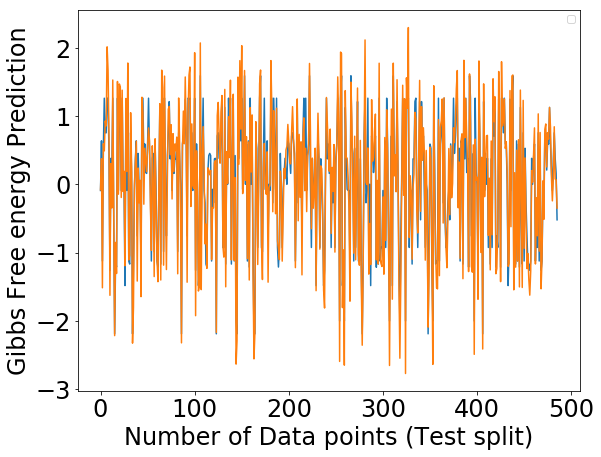

In [68]:
y_pred_test = clf.predict(X_test)
y1  = y_test


fig1 = plt.figure(figsize=(9,7))

plt.legend(['Prediction','Actual Data'])

plt.xlabel('Number of Data points (Test split)', fontsize=24)
plt.ylabel('Gibbs Free energy Prediction', fontsize=24)
plt.tick_params(labelsize=24)

plt.plot(range(0,len(y_pred_test)),y_pred_test)
plt.plot(range(0,len(y1)),y1)
print ('std =',np.std(y_pred_test-y1))
print('score =',clf.score(X_test,y_test))

from sklearn.model_selection import cross_val_score
CV = cross_val_score(clf, X_train, y_train.ravel(), cv=10)
print('Cross Validation =',CV)


### 2b. K-Nearest Neighbors Regression
Implementing KNN regression. Optimal number of nearest neighbors (17) was chosen based on analyzing root mean squared error and mean standard error for different numbers of neighbors

**KNN Regressor Setup**

In [69]:
from sklearn import neighbors

#fit model

knn = neighbors.KNeighborsRegressor(n_neighbors = 10)
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='uniform')

**KNN with 10 nearest neighbors (chosen arbitrarily)**  

10 nearest neighbors was chosen as an inital guess to test KNN setup

std = 0.25697723613856766
score = 0.9420709752896087
Cross Validation = [0.95282366 0.95159363 0.95624332 0.94925741 0.94934963 0.95674321
 0.92021925 0.95916167 0.95414032 0.93607158]


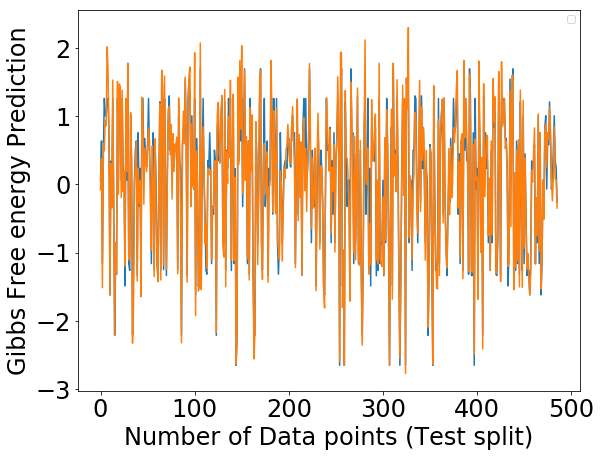

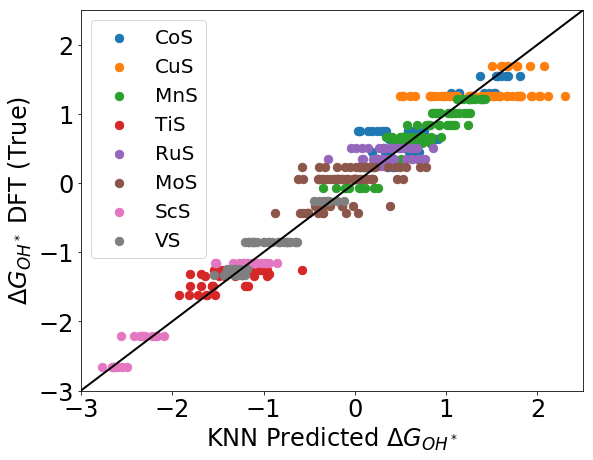

In [70]:
y_pred_test = knn.predict(X_test)
y1  = y_test

fig1 = plt.figure(figsize=(9,7))

plt.legend(['Prediction','Actual Data'])

plt.xlabel('Number of Data points (Test split)', fontsize=24)
plt.ylabel('Gibbs Free energy Prediction', fontsize=24)
plt.tick_params(labelsize=24)

plt.plot(range(0,len(y_pred_test)),y_pred_test)
plt.plot(range(0,len(y1)),y1)
print ('std =',np.std(y_pred_test-y1))
print('score =',knn.score(X_test,y_test))


len_vec=[210,180,240,180,150,210,120,180]
len_vec_cum=np.cumsum(len_vec)
index=np.zeros((len(y1),1))
for i in range(len(y1)):
    pos=(list(DGOH.T)).index(y1[i])
    for j in range(len(len_vec_cum)):
        if pos<len_vec_cum[j]:
            index[i]=j
            break
# Index vector construction done
# Plotting different colors starts here
#print(index.shape)
#print(len(y1))
#print (list(index).count(0))


y1_CoS=[]
y1_CuS=[]
y1_MnS=[]
y1_TiS=[]
y1_RuS=[]
y1_MoS=[]
y1_ScS=[]
y1_VS=[]

yp_CoS=[]
yp_CuS=[]
yp_MnS=[]
yp_TiS=[]
yp_RuS=[]
yp_MoS=[]
yp_ScS=[]
yp_VS=[]
yp=y_pred_test

for i in range(len(y1)):
    if index[i]==0:
        y1_CoS.append(y1[i])
        yp_CoS.append(yp[i])
    if index[i]==1:
        y1_CuS.append(y1[i])
        yp_CuS.append(yp[i])
    if index[i]==2:
        y1_MnS.append(y1[i])
        yp_MnS.append(yp[i])
    if index[i]==3:
        y1_TiS.append(y1[i])
        yp_TiS.append(yp[i])
    if index[i]==4:
        y1_RuS.append(y1[i])
        yp_RuS.append(yp[i])
    if index[i]==5:
        y1_MoS.append(y1[i])
        yp_MoS.append(yp[i])
    if index[i]==6:
        y1_ScS.append(y1[i])
        yp_ScS.append(yp[i])
    if index[i]==7:
        y1_VS.append(y1[i])
        yp_VS.append(yp[i])
        

fig1 = plt.figure(figsize=(9,7))

plt.scatter(y1_CoS, yp_CoS,s=70,label='CoS')
plt.scatter(y1_CuS, yp_CuS, s=70,label='CuS')
plt.scatter(y1_MnS, yp_MnS, s=70,label='MnS')
plt.scatter(y1_TiS, yp_TiS,  s=70,label='TiS')
plt.scatter(y1_RuS, yp_RuS,  s=70,label='RuS')
plt.scatter(y1_MoS, yp_MoS,  s=70,label='MoS')
plt.scatter(y1_ScS, yp_ScS,  s=70,label='ScS')
plt.scatter(y1_VS, yp_VS,  s=70,label='VS')
plt.legend(prop={'size':20})


start=-3
end=2.5
plt.xlim([start,end])
plt.ylim([start,end])
p1=[start,end]
p2=[start,end]
plt.plot(p1,p2,c='black', lw='2', ls='-')
#plt.legend(loc='upper right', frameon=False, prop={'weight':'bold','size':20})
plt.ylabel('$\Delta G_{OH^*}$ DFT (True)', fontsize=24)
plt.xlabel('KNN Predicted $\Delta G_{OH^*}$', fontsize=24)
plt.tick_params(labelsize=24)

plt.savefig('KNN_plot.png', dpi=1200)

from sklearn.model_selection import cross_val_score
CV = cross_val_score(knn, X_train, y_train, cv=10)
print('Cross Validation =',CV)




**Analyze how number of nearest neighbors affect RMSE and MAE**  
This section tells us what the optimal number of nearest neighbors are to reduce the RMSE and MAE

In [71]:
MAE = np.zeros(100)
STD = np.zeros(100)
num_neigh = np.zeros(100)

for i in range(100):
    knn = neighbors.KNeighborsRegressor(n_neighbors = i+1)
    knn.fit(X_train_new, y_train_new)
    y_pred_test = knn.predict(X_test_new)
    y1  = y_test_new
    
    MAE[i] = np.mean(abs(y_pred_test-y1))
    STD[i] = np.std(y_pred_test-y1)
    num_neigh[i] = i+1
#end for loop

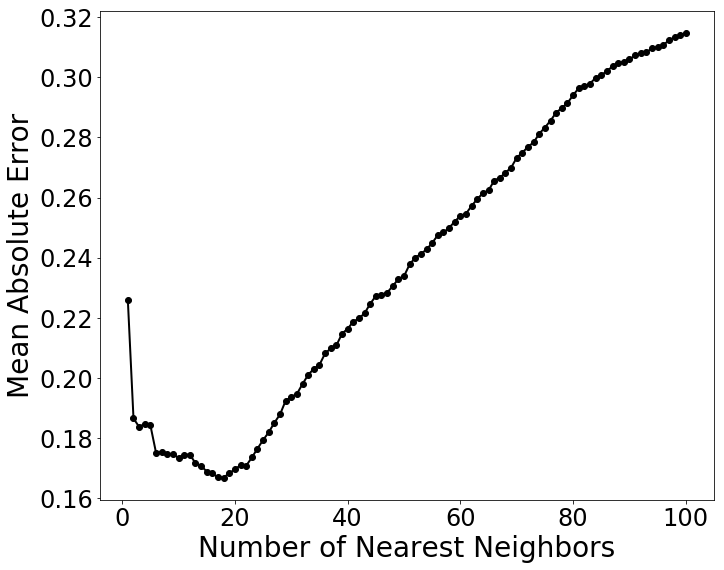

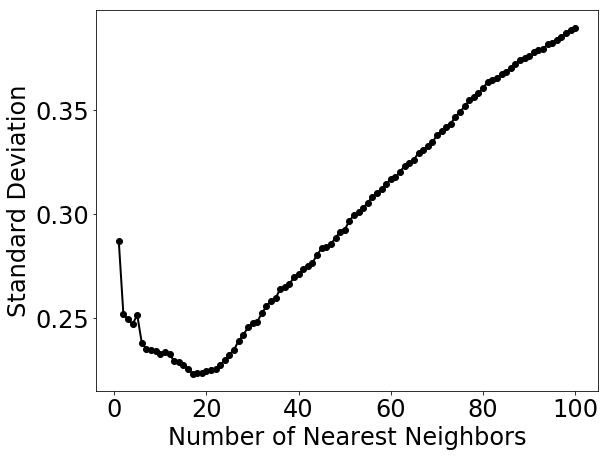

In [72]:
fig1 = plt.figure(figsize=(11,9))
plt.plot(num_neigh,MAE,c='black', lw='2', ls='-', marker='o')
start=-0.5
end=30.5
#plt.xlim([start,end])
#plt.ylim([0.16,0.241])

#plt.legend(loc='upper right', frameon=False, prop={'weight':'bold','size':20})
plt.ylabel('Mean Absolute Error', fontsize=28)
plt.xlabel('Number of Nearest Neighbors', fontsize=28)
plt.tick_params(labelsize=24)

plt.savefig('KNN_MAE_plot2.png', dpi=1400)

fig2 = plt.figure(figsize=(9,7))
plt.plot(num_neigh,STD,c='black', lw='2', ls='-', marker='o')
start=-0.5
end=30.5
#plt.xlim([start,end])
#plt.ylim([start,end])

#plt.legend(loc='upper right', frameon=False, prop={'weight':'bold','size':20})
plt.ylabel('Standard Deviation', fontsize=24)
plt.xlabel('Number of Nearest Neighbors', fontsize=24)
plt.tick_params(labelsize=24)

**Rerun KNN with optimal number of neighbors (17)**

In [73]:
knn = neighbors.KNeighborsRegressor(n_neighbors = 17)
knn.fit(X_train_new, y_train_new)

y_pred_test = knn.predict(X_train_new)
y1  = y_train_new

print ('std =',np.std(y_pred_test-y1))
print ('MAE =',np.mean(abs(y_pred_test-y1)))

print('score =',knn.score(X_train_new,y_train_new))

std = 0.21610400150013764
MAE = 0.16500210406729854
score = 0.9545764464464668


### 2c. Radius Nearest Neighbors Regression
Applying RNN to our dataset.

**RNN Regression Setup**

In [74]:
from sklearn import neighbors

#fit model

rnn = neighbors.RadiusNeighborsRegressor(radius=1)
rnn.fit(X_train_new, y_train_new)

RadiusNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, p=2, radius=1, weights='uniform')

**RNN regression with radius=1 (optimal value)**

std = 0.2636907093853299
MAE = 0.20448278636060446
score = 0.9475158781653994
RMSE 0.26387645616186767
Cross Validation = [0.95522697 0.94589336 0.95819646 0.95029237 0.94613356 0.96150278
 0.93487611 0.96326732 0.94824875 0.94306115]


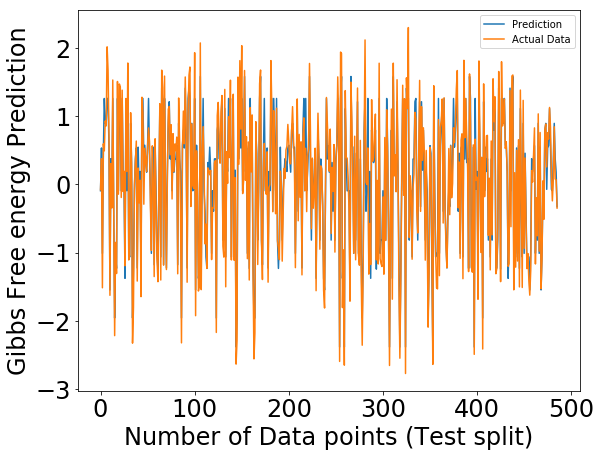

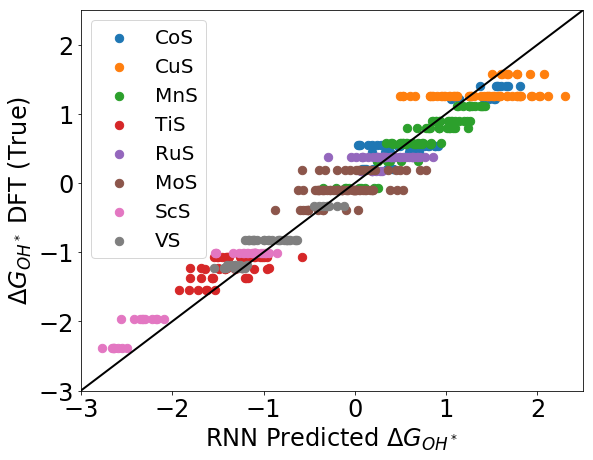

In [75]:
y_pred_test = rnn.predict(X_test_new)
y1  = y_test

fig1 = plt.figure(figsize=(9,7))

plt.plot(range(0,len(y_pred_test)),y_pred_test)
plt.plot(range(0,len(y1)),y1)


plt.legend(['Prediction','Actual Data'])

plt.xlabel('Number of Data points (Test split)', fontsize=24)
plt.ylabel('Gibbs Free energy Prediction', fontsize=24)
plt.tick_params(labelsize=24)

print ('std =',np.std(y_pred_test-y1))
print ('MAE =',np.mean(abs(y_pred_test-y1)))
print('score =',rnn.score(X_test_new,y_test_new))

from sklearn.metrics import mean_squared_error
print('RMSE', np.sqrt(mean_squared_error(y1, y_pred_test)))

len_vec=[210,180,240,180,150,210,120,180]
len_vec_cum=np.cumsum(len_vec)
index=np.zeros((len(y1),1))
for i in range(len(y1)):
    pos=(list(DGOH.T)).index(y1[i])
    for j in range(len(len_vec_cum)):
        if pos<len_vec_cum[j]:
            index[i]=j
            break
# Index vector construction done
# Plotting different colors starts here



y1_CoS=[]
y1_CuS=[]
y1_MnS=[]
y1_TiS=[]
y1_RuS=[]
y1_MoS=[]
y1_ScS=[]
y1_VS=[]

yp_CoS=[]
yp_CuS=[]
yp_MnS=[]
yp_TiS=[]
yp_RuS=[]
yp_MoS=[]
yp_ScS=[]
yp_VS=[]
yp=y_pred_test

for i in range(len(y1)):
    if index[i]==0:
        y1_CoS.append(y1[i])
        yp_CoS.append(yp[i])
    if index[i]==1:
        y1_CuS.append(y1[i])
        yp_CuS.append(yp[i])
    if index[i]==2:
        y1_MnS.append(y1[i])
        yp_MnS.append(yp[i])
    if index[i]==3:
        y1_TiS.append(y1[i])
        yp_TiS.append(yp[i])
    if index[i]==4:
        y1_RuS.append(y1[i])
        yp_RuS.append(yp[i])
    if index[i]==5:
        y1_MoS.append(y1[i])
        yp_MoS.append(yp[i])
    if index[i]==6:
        y1_ScS.append(y1[i])
        yp_ScS.append(yp[i])
    if index[i]==7:
        y1_VS.append(y1[i])
        yp_VS.append(yp[i])
        

fig1 = plt.figure(figsize=(9,7))

plt.scatter(y1_CoS, yp_CoS,s=70,label='CoS')
plt.scatter(y1_CuS, yp_CuS, s=70,label='CuS')
plt.scatter(y1_MnS, yp_MnS, s=70,label='MnS')
plt.scatter(y1_TiS, yp_TiS,  s=70,label='TiS')
plt.scatter(y1_RuS, yp_RuS,  s=70,label='RuS')
plt.scatter(y1_MoS, yp_MoS,  s=70,label='MoS')
plt.scatter(y1_ScS, yp_ScS,  s=70,label='ScS')
plt.scatter(y1_VS, yp_VS,  s=70,label='VS')
plt.legend(prop={'size':20})

start=-3
end=2.5
plt.xlim([start,end])
plt.ylim([start,end])
p1=[start,end]
p2=[start,end]
plt.plot(p1,p2,c='black', lw='2', ls='-')
#plt.legend(loc='upper right', frameon=False, prop={'weight':'bold','size':20})
plt.ylabel('$\Delta G_{OH^*}$ DFT (True)', fontsize=24)
plt.xlabel('RNN Predicted $\Delta G_{OH^*}$', fontsize=24)
plt.tick_params(labelsize=24)

#plt.savefig('RNN_plot.png', dpi=1200)
#plot of std with number of neighbors (inset in other plot)


from sklearn.model_selection import cross_val_score
CV = cross_val_score(rnn, X_train_new, y_train_new, cv=10)
print('Cross Validation =',CV)

**Analyze how radius value influences RMSE and MAE**

In [76]:
MAE = np.zeros(40)
STD = np.zeros(40)
rad = np.linspace(0.5,40,40)

for i in range(40):
    rnn = neighbors.RadiusNeighborsRegressor(radius = rad[i])
    rnn.fit(X_train_new, y_train_new)
    y_pred_test = rnn.predict(X_test_new)
    y1  = y_test_new
    
    MAE[i] = np.mean(abs(y_pred_test-y1))
    STD[i] = np.std(y_pred_test-y1)
#end for loop

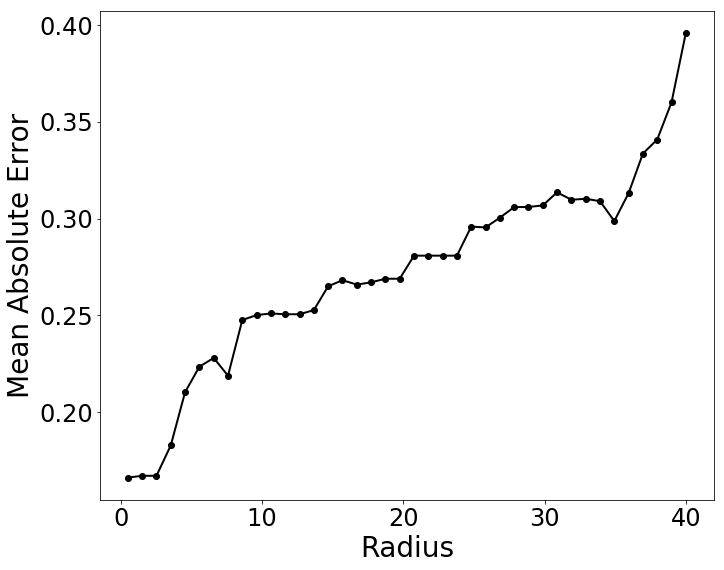

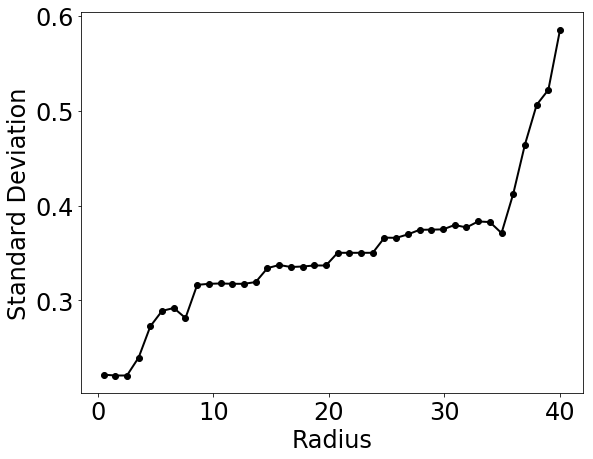

In [77]:
fig1 = plt.figure(figsize=(11,9))
plt.plot(rad,MAE,c='black', lw='2', ls='-', marker='o')
start=0
end=20.5
#plt.xlim([start,end])
#plt.ylim([0.16,0.241])

#plt.legend(loc='upper right', frameon=False, prop={'weight':'bold','size':20})
plt.ylabel('Mean Absolute Error', fontsize=28)
plt.xlabel('Radius', fontsize=28)
plt.tick_params(labelsize=24)

plt.savefig('RNN_MAE_plot.png', dpi=1400)

fig2 = plt.figure(figsize=(9,7))
plt.plot(rad,STD,c='black', lw='2', ls='-', marker='o')
start=0
end=20.5
#plt.xlim([start,end])
#plt.ylim([start,end])

#plt.legend(loc='upper right', frameon=False, prop={'weight':'bold','size':20})
plt.ylabel('Standard Deviation', fontsize=24)
plt.xlabel('Radius', fontsize=24)
plt.tick_params(labelsize=24)

### 2d. Decision Tree Regression
Applying decision tree regression to our dataset, for comparison with SVM, KNN, and RNN regression

**Decision Tree Regressor Setup**

In [78]:
from sklearn import tree

dtr = tree.DecisionTreeRegressor()
dtr.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

**Run Decision Tree Regressor**

Feature Importances = [1.20612887e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.31061415e-01 0.00000000e+00
 0.00000000e+00 1.37751446e-02 1.36783429e-03 0.00000000e+00
 0.00000000e+00 6.03671794e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.26051651e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.15374614e-04 0.00000000e+00
 2.93759683e-02 0.00000000e+00 2.43916632e-01 7.59121405e-02
 0.00000000e+00 0.00000000e+00 2.39306562e-05 1.22124805e-03
 2.92830435e-01 2.41606296e-02 3.55498074e-03 3.65047702e-03
 1.84589030e-03 7.42280568e-05 3.10666663e-03 1.14134202e-02
 1.19041181e-03 0.00000000e+00]
The RMSE for the data is : 0.3128
The MAE for the data is : 0.1868
std = 1.4918697469906588
score = 0.947350847715164
Cross Validation = [0.95568272 0.94

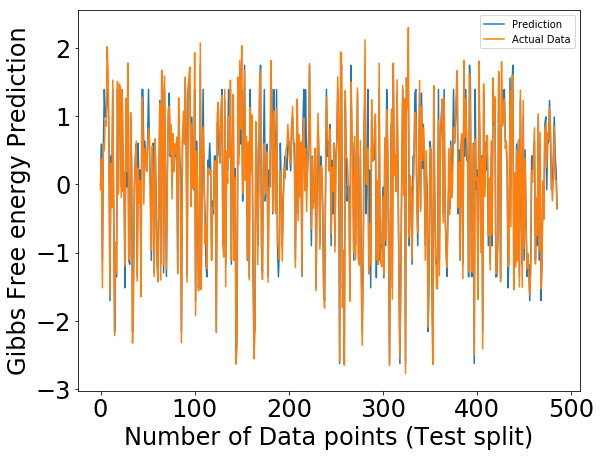

In [79]:
y_pred_test = dtr.predict(X_test)
y1  = y_test

FeatWeights = dtr.feature_importances_
print('Feature Importances =',FeatWeights)
fig1 = plt.figure(figsize=(9,7))



print ('The RMSE for the data is : {0:1.4f}'.format(np.std(y1_pred-y1)))
print ('The MAE for the data is : {0:1.4f}'.format(np.std(abs(y1_pred-y1))))

plt.plot(range(0,len(y_pred_test)),y_pred_test)
plt.plot(range(0,len(y1)),y1)

plt.legend(['Prediction','Actual Data'])

plt.xlabel('Number of Data points (Test split)', fontsize=24)
plt.ylabel('Gibbs Free energy Prediction', fontsize=24)
plt.tick_params(labelsize=24)
print ('std =',np.std(y_pred_test-y1))
print('score =',dtr.score(X_test,y_test))

from sklearn.model_selection import cross_val_score
CV = cross_val_score(dtr, X_train, y_train, cv=10)
print('Cross Validation =',CV)